In [46]:
#import library
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.io as scio 
import scipy.io as sio 
from tensorflow.python.framework import ops
from tfdeterminism import patch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report 
patch()

TensorFlow version 1.14.0 has been patched using tfdeterminism version 0.3.0


In [47]:
import numpy as np
from sklearn.neighbors import KDTree
from scipy.sparse import csr_matrix

def knn_adjacency_matrix(ALL_X, k=10):
    # Build a KDTree to efficiently compute KNN for each point
    tree = KDTree(ALL_X)

    # Initialize the adjacency matrix with zeros
    N = ALL_X.shape[0]
    A = np.zeros((N, N))

    # Compute the KNN graph for each point
    for i in range(N):
        _, indices = tree.query(ALL_X[i:i+1, :], k+1)
        indices = indices[0, 1:]  # exclude self-connection
        A[i, indices] = 1

    # Convert the graph to a sparse matrix and return it
    ALL_L = csr_matrix(A)
    return ALL_L


In [48]:
def split_data(Labeled_points, Labels, test_size=0.3, random_state=0):
     

    # Set the random seed, if provided
    if random_state is not None:
        np.random.seed(random_state)

    # Get the number of data points
    num_points = Labeled_points.shape[0]

    # Calculate the number of points to use for testing
    num_test = int(num_points * test_size)

    # Shuffle the indices of the data points
    indices = np.random.permutation(num_points)

    # Split the indices into training and testing sets
    test_indices = indices[:num_test]
    train_indices = indices[num_test:]

    # Use the indices to get the training and testing data points and labels
    X_train = Labeled_points[train_indices]
    X_test = Labeled_points[test_indices]
    y_train = Labels[train_indices]
    y_test = Labels[test_indices]

    return X_train, X_test, y_train, y_test


In [49]:
import math


def random_mini_batches_GCN(X, Y, L, mini_batch_size, seed):
    
    m = X.shape[0]
    mini_batches = []
    np.random.seed(seed)
    
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation, :]
    shuffled_Y = Y[permutation, :].reshape((m, Y.shape[1]))
    shuffled_L1 = L[permutation, :].reshape((L.shape[0], L.shape[1]), order = "F")
    shuffled_L = shuffled_L1[:, permutation].reshape((L.shape[0], L.shape[1]), order = "F")

    num_complete_minibatches = math.floor(m / mini_batch_size)
    
    for k in range(0, num_complete_minibatches):       
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size, :]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size, :]
        mini_batch_L = shuffled_L[k * mini_batch_size : k * mini_batch_size + mini_batch_size, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y, mini_batch_L)
        mini_batches.append(mini_batch)
    mini_batch = (X, Y, L) 
    mini_batches.append(mini_batch)
    
    return mini_batches

In [50]:
def create_placeholders(n_x, n_y):

    isTraining = tf.placeholder_with_default(True, shape=())
    x_in = tf.placeholder(tf.float32,  [None, n_x], name = "x_in")
    y_in = tf.placeholder(tf.float32, [None, n_y], name = "y_in")
    lap_train = tf.placeholder(tf.float32, [None, None], name = "lap_train")
    
    return x_in, y_in, lap_train, isTraining


In [51]:
def initialize_parameters():
   
    tf.set_random_seed(1)

    x_w1 = tf.get_variable("x_w1", [224,128], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    x_b1 = tf.get_variable("x_b1", [128], initializer = tf.zeros_initializer())

    x_w2 = tf.get_variable("x_w2", [128,12], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    x_b2 = tf.get_variable("x_b2", [12], initializer = tf.zeros_initializer())    

    
    parameters = {"x_w1": x_w1,
                  "x_b1": x_b1,
                  "x_w2": x_w2,
                  "x_b2": x_b2}
                  
    return parameters

In [52]:
def GCN_layer(x_in, L_, weights):

    x_mid = tf.matmul(x_in, weights)
    x_out = tf.matmul(L_, x_mid)
    
    return x_out



In [53]:
def mynetwork(x, parameters, Lap, isTraining, momentums = 0.9):

    with tf.name_scope("x_layer_1"):

         x_z1_bn = tf.layers.batch_normalization(x, momentum = momentums, training = isTraining)             
         x_z1 = GCN_layer(x_z1_bn, Lap, parameters['x_w1']) + parameters['x_b1']
         x_z1_bn = tf.layers.batch_normalization(x_z1, momentum = momentums, training = isTraining)
         x_a1 = tf.nn.relu(x_z1_bn)      
         
    with tf.name_scope("x_layer_3"):
        
         x_z2_bn = tf.layers.batch_normalization(x_a1, momentum = momentums, training = isTraining)        
         x_z2 = GCN_layer(x_z2_bn, Lap, parameters['x_w2']) + parameters['x_b2']         

    l2_loss =  tf.nn.l2_loss(parameters['x_w1']) + tf.nn.l2_loss(parameters['x_w2'])
                
    return x_z2, l2_loss


In [54]:
def mynetwork_optimaization(y_est, y_re, l2_loss, reg, learning_rate, global_step):
    
    y_re = tf.squeeze(y_re, name = 'y_re')
    
    with tf.name_scope("cost"):
         cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = y_est, labels = y_re)) +  reg * l2_loss
         
    with tf.name_scope("optimization"):
         update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
         optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost,  global_step=global_step)
         optimizer = tf.group([optimizer, update_ops])
         
    return cost, optimizer



In [55]:
def network_accuracy(x_out, y_in):
    
    correct_prediction = tf.equal(tf.argmax(x_out, 1), tf.argmax(y_in, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
         
    return accuracy

In [56]:
def train_mynetwork(x_train, x_test, y_train, y_test, L_train, L_test, learning_rate_base = 0.001, beta_reg = 0.001, num_epochs = 200, minibatch_size = 32, print_cost = True):
    
    ops.reset_default_graph()    
    tf.set_random_seed(1)                          
    seed = 1                                                         
    (m, n_x) = x_train.shape
    (m, n_y) = y_train.shape
    
    costs = []                                        
    costs_dev = []
    train_acc = []
    val_acc = []
    
    x_in, y_in, lap_train, isTraining = create_placeholders(n_x, n_y) 

    parameters = initialize_parameters()
    
    with tf.name_scope("network"):
         x_out, l2_loss = mynetwork(x_in, parameters, lap_train, isTraining)

    global_step = tf.Variable(0, trainable=False)
    learning_rate = tf.train.exponential_decay(learning_rate_base, global_step, 50 * m/minibatch_size, 0.5, staircase = True)
    
    with tf.name_scope("optimization"):
         cost, optimizer = mynetwork_optimaization(x_out, y_in, l2_loss, beta_reg, learning_rate, global_step)

    with tf.name_scope("metrics"):
         accuracy = network_accuracy(x_out, y_in)

    init = tf.global_variables_initializer()

    with tf.Session() as sess:
        
        sess.run(init)
      
        # Do the training loop
        for epoch in range(num_epochs + 1):
            epoch_cost = 0.
            epoch_acc = 0.
            
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            
            minibatches = random_mini_batches_GCN(x_train, y_train, L_train, minibatch_size, seed)
            
            for minibatch in minibatches:

                # Select a minibatch
                (batch_x, batch_y, batch_l) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                _, minibatch_cost, minibatch_acc = sess.run([optimizer, cost, accuracy], feed_dict={x_in: batch_x, y_in: batch_y, lap_train: batch_l, isTraining: True})           
                epoch_cost += minibatch_cost 
                epoch_acc += minibatch_acc

            epoch_cost_train = epoch_cost / (num_minibatches+ 1) 
            epoch_acc_train = epoch_acc / (num_minibatches+ 1) 

           
            if print_cost == True and epoch % 50 == 0:
                features, epoch_cost_test, epoch_acc_test = sess.run([x_out, cost, accuracy], feed_dict={x_in: x_test, y_in: y_test, lap_train: L_test, isTraining: False})
                print ("epoch %i: Train_loss: %f, Val_loss: %f, Train_acc: %f, Val_acc: %f" % (epoch, epoch_cost_train, epoch_cost_test, epoch_acc_train, epoch_acc_test))
            
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost_train)
                train_acc.append(epoch_acc_train)
                costs_dev.append(epoch_cost_test)
                val_acc.append(epoch_acc_test)

        # plot the cost      
        plt.plot(np.squeeze(costs))
        plt.plot(np.squeeze(costs_dev))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
        # plot the accuracy 
        plt.plot(np.squeeze(train_acc))
        plt.plot(np.squeeze(val_acc))
        plt.ylabel('accuracy')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
      
        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")
       
       
        return parameters, val_acc, features



Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



epoch 0: Train_loss: 2.992894, Val_loss: 6.218272, Train_acc: 0.163836, Val_acc: 0.266667
epoch 50: Train_loss: 2.009755, Val_loss: 5.928091, Train_acc: 0.334749, Val_acc: 0.549206
epoch 100: Train_loss: 1.914636, Val_loss: 5.571173, Train_acc: 0.360168, Val_acc: 0.565079
epoch 150: Train_loss: 2.012842, Val_loss: 5.646367, Train_acc: 0.321954, Val_acc: 0.539683
epoch 200: Train_loss: 1.925369, Val_loss: 5.815443, Train_acc: 0.358752, Val_acc: 0.584127


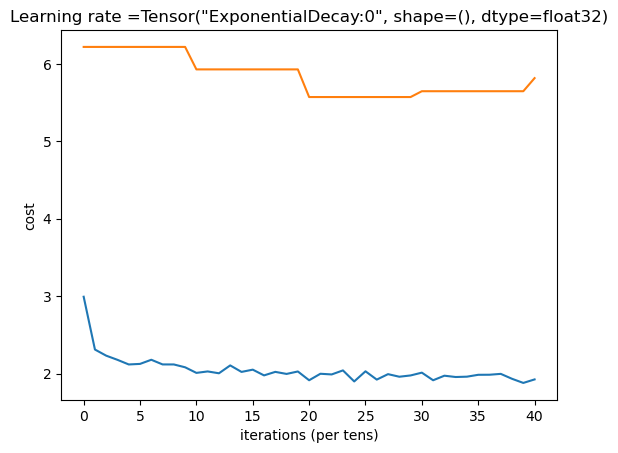

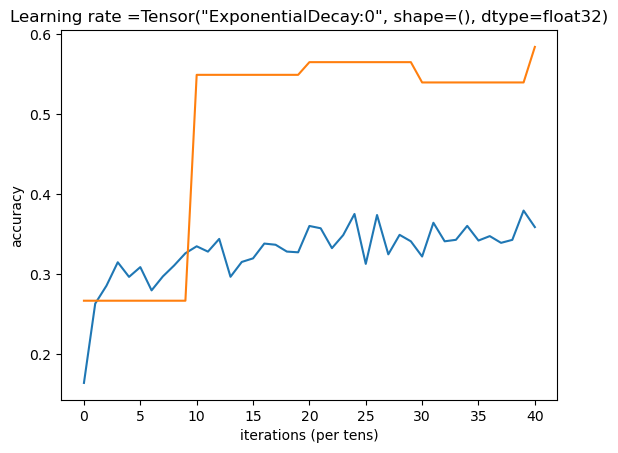

Parameters have been trained!
(315,) (315,)
Confusion Matrix:
 [[15  0  0  2  0  6  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0  3  7  4  2  0]
 [ 0  1  0  0  0  0  0  5  0  0  0  0]
 [ 1  0  0  6  0  5  0  4  0  0  0  0]
 [ 0  0  0  0 25  0  0  0 12  1  2  0]
 [ 0  0  0  0  0  6  0  2  5  0  0  0]
 [ 0  1  0  2  0  3  0  2  2  0  0  6]
 [ 0  2  0  0  0  0  0 17  7  0  0  0]
 [ 0  3  0  0  0  0  0  4 55  0  0  0]
 [ 0  9  0  0  0  0  0  0  0 31  6  1]
 [ 0  0  0  0  0  0  0  0  0 18 15  0]
 [ 0  0  0  0  0  1  0  2  0  0  0  3]]
Accuracy: 0.5841269841269842
Precision: 0.48046610025776687
Recall: 0.4730152193883008
F1-score: 0.4602384671447675
ROC AUC score: 0.8685113569056419


In [57]:
import scipy
import scipy.sparse as sp
import warnings
warnings.filterwarnings('ignore')
 
 
Labeled_points = scipy.io.loadmat('Labeled_Cuprite_Data/data_points.mat')['data_points']
maxVal = np.amax(Labeled_points)
minVal = np.amin(Labeled_points) 
Labeled_points_shifted = Labeled_points + abs(minVal) 
Labeled_points_norm = Labeled_points_shifted / (abs(minVal) + abs(maxVal))
Labeled_points_norm = Labeled_points_norm + 1e-6 

Labels = scipy.io.loadmat('Labeled_Cuprite_Data/labels.mat')['labels']
Labels = Labels.T
num_classes = 12
Labels_onehot = tf.keras.utils.to_categorical(Labels, num_classes) 

X_train, X_test, Y_train, Y_test = split_data(Labeled_points_norm, Labels_onehot, test_size=0.3) 

 
train_L = knn_adjacency_matrix(X_train)
test_L = knn_adjacency_matrix(X_test)


  
parameters, val_acc, features = train_mynetwork(X_train, X_test, Y_train, Y_test, train_L.todense() ,test_L.todense())
y_pred = np.argmax(features, axis=1)
y_true = np.argmax(Y_test, axis=1) 

print(y_pred.shape, y_true.shape)
# create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# print confusion matrix
print("Confusion Matrix:\n", cm)

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred, average='macro'))
print("Recall:", recall_score(y_true, y_pred, average='macro'))
print("F1-score:", f1_score(y_true, y_pred, average='macro'))
print("ROC AUC score:", roc_auc_score(Y_test, features, multi_class='ovr'))

